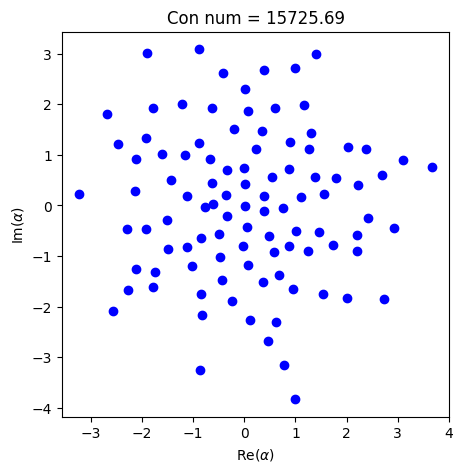

max dis amplitude is 3.9600982520472354

--- 418.1373863220215 seconds ---


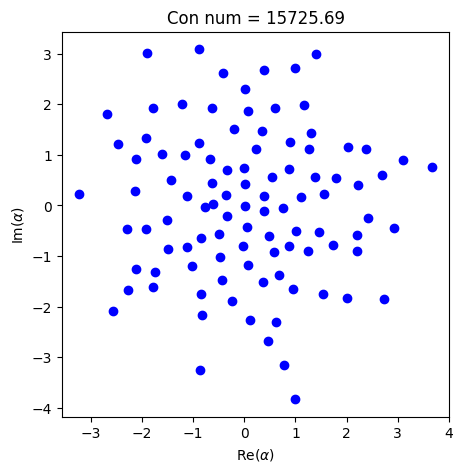

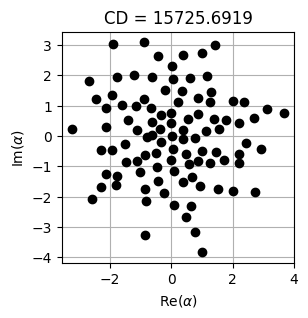

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from scipy.linalg import expm
from scipy.optimize import minimize
from IPython.display import display , clear_output
from qutip import *#destroy, Qobj, basis
from QN_regression import QN_regression
import time
start_time = time.time()#checking how long the code takes

FD = 10
# Number of displacements
n_disps = FD**2-1

N = 50#cavity dimension
d = FD#dimension to read
a = destroy(N).full()
ad = np.conj(np.transpose(a))

#projection operators
P = np.zeros([d,N,N], dtype=np.complex_)
for j in range(d):
    P[j] = (basis(N,j)*basis(N,j).dag()).full()

NN = 1#different seeds for optimisation later
st = 1#strength of random initial displacements

#which probability to measure: P_0, ..., P_(d-1)
PN = np.zeros(d, dtype = np.int_)
#PN[d-1] = d**2-1
PN[0] = d**2-1
#getting the K matrix, rho=K*Y+theta
Ntr = FD**2
X_R = np.zeros([1+n_disps, Ntr],dtype=np.complex_) #store readouts
X_R[0,:] = np.ones([1, Ntr]) #setting the ones
Y_R = np.zeros([FD**2, Ntr],dtype=np.complex_) #store the targets
for j in np.arange(0, Ntr):
    #qudit mixed state embedded in the cavity mode
    rd1 = np.zeros([N, N], dtype = np.complex_)
    u_rand = rand_ket(FD)
    r_rand = (u_rand*u_rand.dag()).full()
    rd1[0:FD,0:FD] = r_rand#randRho(D)

    #assign X_r
    cw = 1
    #diagonal elements
    for j1 in np.arange(0, FD-1):
        X_R[cw, j] = rd1[j1, j1].real
        cw += 1
    #off-diagonal elements
    for j1 in np.arange(0, FD-1):
        for j2 in np.arange(j1+1, FD):
            X_R[cw, j] = rd1[j1, j2].real
            cw += 1
            X_R[cw, j] = rd1[j1, j2].imag
            cw += 1
    
    #assign Y_r
    Y_R[:,j] = np.transpose((np.transpose(r_rand)).reshape((FD**2,1)))#ideal rvec
Error, beta = QN_regression(X_R, Y_R, 0)
print(f'Error is {Error}')
K = beta[:,1:n_disps+1]

def wigner_mat(disps):
    ND = len(disps)#no of exp points/displacements, equals n_disps
    M = np.zeros([ND, d**2],dtype =complex)#the big map (truncated)
    ct = 0
    for jj in range(len(PN)):#running through PN
        if PN[jj]>0:#if >0 then we add to the map
            for k in range(PN[jj]):
                beta = disps[ct]
                D = expm(beta*ad-np.conj(beta)*a)
                Ms = D@P[jj]@np.conj(np.transpose(D))#displacement is applied same as parity
                Mst = Ms[0:d,0:d]#truncation starts here
                M[ct,:] = Mst.reshape((1, d**2))
                ct += 1
    # print(M.shape)
    M_new = np.matmul(M,K)
    return M_new

def wigner_mat_and_grad(disps):
    ND = len(disps)#no of exp points/displacements, equals n_disps
    wig_tens = np.zeros((ND, FD**2), dtype=complex)
    grad_mat_r = np.zeros((ND, FD**2), dtype=complex)
    grad_mat_i = np.zeros((ND, FD**2), dtype=complex)

    wig_tens = wigner_mat(disps)
    disps_dr = disps+0.01
    disps_di = disps+0.01j
    wig_tens_dr = wigner_mat(disps_dr)
    wig_tens_di = wigner_mat(disps_di)
    grad_mat_r = (wig_tens_dr-wig_tens)/0.01
    grad_mat_i = (wig_tens_di-wig_tens)/0.01

    return (wig_tens, grad_mat_r, grad_mat_i)

def cost_and_grad(r_disps):
    N = len(r_disps)
    c_disps = r_disps[:int(N/2)] + 1j*r_disps[int(N/2):]#now complex displacements
    M, dM_rs, dM_is = wigner_mat_and_grad (c_disps)
    U, S, Vd = svd(M)
    NS = len(Vd)
    cn = S[0] / S[-1]
    dS_r = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs , Vd.conj().T).real
    dS_i = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is , Vd.conj().T).real
    grad_cn_r = (dS_r[0]*S[-1] - S[0]*dS_r[-1])/(S[-1]**2)
    grad_cn_i = (dS_i[0]*S[-1] - S[0]*dS_i[-1])/(S[-1]**2)
    return cn, np.concatenate(( grad_cn_r , grad_cn_i))

best_cost = float('inf')
f, ax = plt.subplots(figsize=(5, 5))

def wrap_cost(disps):
    global best_cost
    cost , grad = cost_and_grad(disps)
    best_cost = min(cost , best_cost)
    ax.clear()
    ax.plot(disps[:n_disps], disps[n_disps:], 'ob')#ok 
    ax.set_title('Con num = %.2f' % (cost,))
    ax.set_xlabel('Re'+r'$(\alpha)$')
    ax.set_ylabel('Im'+r'$(\alpha)$')
    clear_output(wait=True)
    display(f)
    return cost , grad


CD = np.zeros(NN)
DIS = np.zeros([NN,n_disps], dtype=np.complex_)
for vv in np.arange(0,NN):
    init_disps = np.random.normal(0, st, 2*n_disps)#random numbers
    # init_disps = np.array([ 1.47550433, -1.07029609, -0.10366203, -0.56023532, -0.26149839,-1.01849083,  0.95176108,  1.63069871])
    # for k in np.arange(len(new_disps)):
    #     init_disps[k] = new_disps[k].real
    #     init_disps[k+n_disps] = new_disps[k].imag

    # init_disps[0] = init_disps[n_disps] = 0#putting zeros, corresponding to 0,0j
    ret = minimize(wrap_cost , init_disps , method='L-BFGS-B', jac=True , options=dict(ftol=1e-6))
    # print(ret.message)

    new_disps = ret.x[:n_disps] + 1j*ret.x[n_disps:]

    CD[vv] = ret.fun
    DIS[vv,:] = new_disps
# print(min(CD))

sorted_index = np.argsort(CD)
final_disps = DIS[sorted_index[0],:]
final_CD = CD[sorted_index[0]]
#plotting the optimum displacements
fig = plt.figure(figsize = (3,3))
for k in np.arange(0,len(final_disps)):
    plt.plot(final_disps[k].real,final_disps[k].imag,'ok')
plt.xlabel('Re'+r'$(\alpha)$')
plt.ylabel('Im'+r'$(\alpha)$')
plt.title('CD = %.4f' % (final_CD))
plt.grid()

# np.savez('d8_disps.npz',AL=final_disps)

cabs = np.zeros(len(final_disps))
for j in range(len(final_disps)):
    # if np.abs(final_disps[j])>=2:
    cabs[j] = np.abs(final_disps[j])
        # c_disps[j] = c_disps[j]/cabs
print(f'max dis amplitude is {np.max(cabs)}')

print("")
print("--- %s seconds ---" % (time.time() - start_time))

# %%

In [19]:
np.save('pns_disps10,d=0', final_disps)

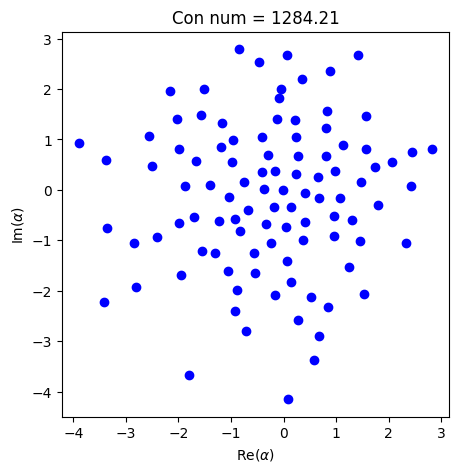

max dis amplitude is 4.149491804032063

--- 323.3763072490692 seconds ---


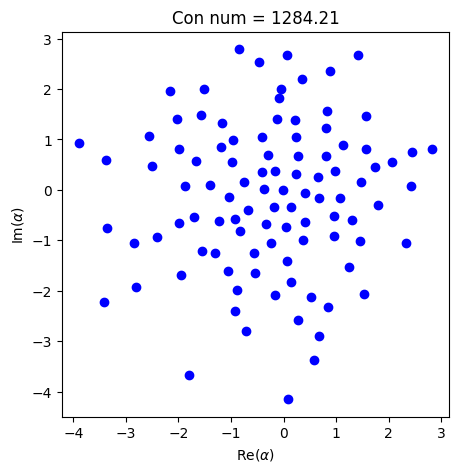

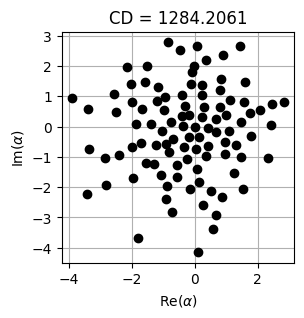

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from scipy.linalg import expm
from scipy.optimize import minimize
from IPython.display import display , clear_output
from qutip import *#destroy, Qobj, basis
from QN_regression import QN_regression
import time
start_time = time.time()#checking how long the code takes

FD = 10
# Number of displacements
n_disps = FD**2-1

N = 50#cavity dimension
d = FD#dimension to read
a = destroy(N).full()
ad = np.conj(np.transpose(a))

#projection operators
P = np.zeros([d,N,N], dtype=np.complex_)
for j in range(d):
    P[j] = (basis(N,j)*basis(N,j).dag()).full()

NN = 1#different seeds for optimisation later
st = 1.5#strength of random initial displacements

#which probability to measure: P_0, ..., P_(d-1)
PN = np.zeros(d, dtype = np.int_)

PN[d-1] = d**2-1
#getting the K matrix, rho=K*Y+theta
Ntr = FD**2
X_R = np.zeros([1+n_disps, Ntr],dtype=np.complex_) #store readouts
X_R[0,:] = np.ones([1, Ntr]) #setting the ones
Y_R = np.zeros([FD**2, Ntr],dtype=np.complex_) #store the targets
for j in np.arange(0, Ntr):
    #qudit mixed state embedded in the cavity mode
    rd1 = np.zeros([N, N], dtype = np.complex_)
    u_rand = rand_ket(FD)
    r_rand = (u_rand*u_rand.dag()).full()
    rd1[0:FD,0:FD] = r_rand#randRho(D)

    #assign X_r
    cw = 1
    #diagonal elements
    for j1 in np.arange(0, FD-1):
        X_R[cw, j] = rd1[j1, j1].real
        cw += 1
    #off-diagonal elements
    for j1 in np.arange(0, FD-1):
        for j2 in np.arange(j1+1, FD):
            X_R[cw, j] = rd1[j1, j2].real
            cw += 1
            X_R[cw, j] = rd1[j1, j2].imag
            cw += 1
    
    #assign Y_r
    Y_R[:,j] = np.transpose((np.transpose(r_rand)).reshape((FD**2,1)))#ideal rvec
Error, beta = QN_regression(X_R, Y_R, 0)
print(f'Error is {Error}')
K = beta[:,1:n_disps+1]

def wigner_mat(disps):
    ND = len(disps)#no of exp points/displacements, equals n_disps
    M = np.zeros([ND, d**2],dtype =complex)#the big map (truncated)
    ct = 0
    for jj in range(len(PN)):#running through PN
        if PN[jj]>0:#if >0 then we add to the map
            for k in range(PN[jj]):
                beta = disps[ct]
                D = expm(beta*ad-np.conj(beta)*a)
                Ms = D@P[jj]@np.conj(np.transpose(D))#displacement is applied same as parity
                Mst = Ms[0:d,0:d]#truncation starts here
                M[ct,:] = Mst.reshape((1, d**2))
                ct += 1
    # print(M.shape)
    M_new = np.matmul(M,K)
    return M_new

def wigner_mat_and_grad(disps):
    ND = len(disps)#no of exp points/displacements, equals n_disps
    wig_tens = np.zeros((ND, FD**2), dtype=complex)
    grad_mat_r = np.zeros((ND, FD**2), dtype=complex)
    grad_mat_i = np.zeros((ND, FD**2), dtype=complex)

    wig_tens = wigner_mat(disps)
    disps_dr = disps+0.01
    disps_di = disps+0.01j
    wig_tens_dr = wigner_mat(disps_dr)
    wig_tens_di = wigner_mat(disps_di)
    grad_mat_r = (wig_tens_dr-wig_tens)/0.01
    grad_mat_i = (wig_tens_di-wig_tens)/0.01

    return (wig_tens, grad_mat_r, grad_mat_i)

def cost_and_grad(r_disps):
    N = len(r_disps)
    c_disps = r_disps[:int(N/2)] + 1j*r_disps[int(N/2):]#now complex displacements
    M, dM_rs, dM_is = wigner_mat_and_grad (c_disps)
    U, S, Vd = svd(M)
    NS = len(Vd)
    cn = S[0] / S[-1]
    dS_r = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs , Vd.conj().T).real
    dS_i = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is , Vd.conj().T).real
    grad_cn_r = (dS_r[0]*S[-1] - S[0]*dS_r[-1])/(S[-1]**2)
    grad_cn_i = (dS_i[0]*S[-1] - S[0]*dS_i[-1])/(S[-1]**2)
    return cn, np.concatenate(( grad_cn_r , grad_cn_i))

best_cost = float('inf')
f, ax = plt.subplots(figsize=(5, 5))

def wrap_cost(disps):
    global best_cost
    cost , grad = cost_and_grad(disps)
    best_cost = min(cost , best_cost)
    ax.clear()
    ax.plot(disps[:n_disps], disps[n_disps:], 'ob')#ok 
    ax.set_title('Con num = %.2f' % (cost,))
    ax.set_xlabel('Re'+r'$(\alpha)$')
    ax.set_ylabel('Im'+r'$(\alpha)$')
    clear_output(wait=True)
    display(f)
    return cost , grad


CD = np.zeros(NN)
DIS = np.zeros([NN,n_disps], dtype=np.complex_)
for vv in np.arange(0,NN):
    init_disps = np.random.normal(0, st, 2*n_disps)#random numbers
    # init_disps = np.array([ 1.47550433, -1.07029609, -0.10366203, -0.56023532, -0.26149839,-1.01849083,  0.95176108,  1.63069871])
    # for k in np.arange(len(new_disps)):
    #     init_disps[k] = new_disps[k].real
    #     init_disps[k+n_disps] = new_disps[k].imag

    # init_disps[0] = init_disps[n_disps] = 0#putting zeros, corresponding to 0,0j
    ret = minimize(wrap_cost , init_disps , method='L-BFGS-B', jac=True , options=dict(ftol=1e-6))
    # print(ret.message)

    new_disps = ret.x[:n_disps] + 1j*ret.x[n_disps:]

    CD[vv] = ret.fun
    DIS[vv,:] = new_disps
# print(min(CD))

sorted_index = np.argsort(CD)
final_disps = DIS[sorted_index[0],:]
final_CD = CD[sorted_index[0]]
#plotting the optimum displacements
fig = plt.figure(figsize = (3,3))
for k in np.arange(0,len(final_disps)):
    plt.plot(final_disps[k].real,final_disps[k].imag,'ok')
plt.xlabel('Re'+r'$(\alpha)$')
plt.ylabel('Im'+r'$(\alpha)$')
plt.title('CD = %.4f' % (final_CD))
plt.grid()

# np.savez('d8_disps.npz',AL=final_disps)

cabs = np.zeros(len(final_disps))
for j in range(len(final_disps)):
    # if np.abs(final_disps[j])>=2:
    cabs[j] = np.abs(final_disps[j])
        # c_disps[j] = c_disps[j]/cabs
print(f'max dis amplitude is {np.max(cabs)}')

print("")
print("--- %s seconds ---" % (time.time() - start_time))

# %%

In [15]:
np.save('pns_disps10,d=1', final_disps)